# Ausgewählte Kapitel sozial Webtechnologien - Neuronale Netze
## Trainieren eines Word2Vec Modells und Darstellung von Wort- und Dokumentenvektoren anhand von Anfragetexten des FragDenStaat-Projektes

Bearbeiten von:
* Sebastian Jüngling (558556)
* Konstantin Bruckert (558290)

Prüfer:
* Benjamin Voigt

# Einleitung
Über das FragDenStaat-Portal werden Anfragen an Behörden in Deutschland gesammelt und zur Verfügung gestellt. Durch die stetig wachsende Popularität des Portals liegt diesem Projekt ein umfangreicher Datensatz vor, dessen Informationsgehalt im Laufe dieses Notebooks mit Hilfe eines Word2Vec Modells möglichst weit ausgeschöpft werden soll.

Grober Ablauf: Zunächst werden die bereits bereinigten Daten für die Weiterverarbeitung aufbereitet und randomisiert. Tatsächliche Input-Daten werden daraufhin durch die indexierung und Speicherung in Lookup-Tables generiert. Mithilfe von Context-Windows können nun Input-Target-Wörter mit entsprechenden Labels aus Daten abgeleitet und für alle Sätze erzeugt werden. Das eigentlich Kernstück des Notebooks bildet dann das Skip-Gramm Modell als Hidden-Layer, welches in sequentiellen Batches über mehrere Epochen die Weights per Loss trainiert. Die daraus resultierenden Word-Embeddings können nun genutzt werden um Dokumenten-Vektoren aufzubauen. Diese oder auch einfache Wort-Vektoren können mithilfe der Cosine-Similarity verglichen werden. Abschließend wird versucht, die Word-Embeddings in verschieden Arten und unter zuhilfenahme des TSNE-Algorithmus zu visualiseren bzw. Ähnlichkeiten zu clustern.

Für allgemeine hintergrundinformationen zu den einzelnen hier im Modul angewandte Techniken und auch Details zur Entscheidungsfindung lohnt sich zudem ein Blick in das [Exposé](Documents/NN-Projekt-Expose.pdf).



In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import sys
from tempfile import gettempdir

import numpy as np
from six.moves import xrange
import tensorflow as tf

import pandas as pd

from sklearn.manifold import TSNE

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *

init_notebook_mode(connected=True)

%matplotlib inline
import matplotlib.pyplot as plt

# Daten:
Hier passiert das Einladen des Anfragen-Katalogs des FragDenStaat-Projektes.  
Die Daten wurden schon im Zuge der Werkstudententätigkeit von S. Jüngling im Vorfeld bezogen und weitestgehend aufbereitet.
Dabei wurden die Texte auf ihre bedeutungstragenden Begriffe reduziert und die Wörter lemmatisiert.

Bitte achten Sie darauf, die Daten gemäß der Anleitung in der README.md Datei herunterzuladen.

In [2]:
data = pd.read_json('fds_requests_preprocessed.json', orient='records', encoding='utf-8')
data = data.set_index('id') #set column 'id' as index

In [3]:
data.head()

,description,preprocessed,textrank,title
id,,,,
47033,1. Wann haben die beiden letzten lebensmittelr...,"[[kontrollbericht, parkstern, berlin], [betrie...","[[parkstern, Parkstern, 1.1227777778], [berlin...","Kontrollbericht zu Parkstern, Berlin"
131943,Die Stellungnahme des BfR zur IARC- Monographi...,"[[stellungnahme, bfr], [iarc, monographie, gly...","[[stellungnahme, Stellungnahme, 1.0], [bfr, Bf...",Stellungnahme des BfR zur IARC- Monographie üb...
47827,1. Wann haben die beiden letzten lebensmittelr...,"[[kontrollbericht, aroma, berlin], [betriebsüb...","[[aroma, Aroma, 1.1227777778], [berlin, Berlin...","Kontrollbericht zu Aroma, Berlin"
131938,Die Stellungnahme des BfR zur IARC- Monographi...,"[[stellungnahme, bfr], [iarc, monographie, gly...","[[stellungnahme, Stellungnahme, 1.0], [bfr, Bf...",Stellungnahme des BfR zur IARC- Monographie üb...
48091,1. Wann haben die beiden letzten lebensmittelr...,"[[kontrollbericht], [hans, glück, bonn], [betr...","[[bonn, Bonn, 1.2479166667000001], [hans, Hans...","Kontrollbericht zu ""Hans im Glück"", Bonn"


### Beispiel für Preprocessing des Anfragetextes:

In [4]:
print('Titel und Description für Beispielanfrage:\n')
print(data.loc[47827]['title'])
print(data.loc[47827]['description'])

print('-------------------------------------------------------------------------')

print('\nPreprocessed Anfragetext für Titel und Anfragetext:\n')
print(data.loc[47827]['preprocessed'])

Titel und Description für Beispielanfrage:

Kontrollbericht zu Aroma, Berlin
1. Wann haben die beiden letzten lebensmittelrechtlichen Betriebsüberprüfungen im folgenden Betrieb stattgefunden:
Aroma
Kantstraße
10625 Berlin

2. Kam es hierbei zu Beanstandungen? Falls ja, beantrage ich hiermit die Herausgabe des entsprechenden Kontrollberichts an mich.
-------------------------------------------------------------------------

Preprocessed Anfragetext für Titel und Anfragetext:

[['kontrollbericht', 'aroma', 'berlin'], ['betriebsüberprüfungen', 'betrieb'], ['aroma', 'kantstraße', 'berlin'], ['beanstandung'], ['herausgabe', 'kontrollberichts']]


### Reduzierung der Anzahl der Anfragen zu Glyphosat
Immer wieder kommt es bei FragDenStaat zu einer Häufung tagespolitischer Themen, wie z.B. die Fragen rund um das Thema Glyphosat. Seit März 2019 sind hierzu bereits mehr als 30.000 Anfragen eingegangen, welche Anhand eines immergleichen Musters ausformuliert werden und somit das Training der globalen Datenmenge zu stark beeinflussen. Zur Reduzierung dieses Einflusses werden die Anfragen zu diesem Thema bei 3000 gedeckelt.
Um auch in Zukunft und ggf. bei der Nutzung aktuellerer/andersartiger Datensätze einwandfreie Ergebnisse zu erzielen, sollte regelmäßig geprüft werden, ob die Daten von einem bestimmten Thema dominiert werden.

In [5]:
glyphosat_title = 'Stellungnahme des BfR zur IARC- Monographie über Glyphosat'
glyphosat_ids = data[data['title'] == glyphosat_title].index

print('Anzahl der Anfragen zu Glyphosat:', len(glyphosat_ids), 'von insgesamt:', len(data), 'Anfragen')

# Da dies alle gleiche Anfragen sind und diese hohe Anzahl den Trainingsprozess verfälschen würde, 
# wird die Anzahl der Anfragen zu Glyphosat auf 3000 beschränkt
remain_glyphosat_requests = 3000
data.drop(glyphosat_ids[remain_glyphosat_requests:], inplace=True) # drop by id

print('Anzahl der Anfragen zu Glyphosat nach Bereinigung:', len(data[data['title'] == glyphosat_title]), 'von insgesamt:', len(data), 'Anfragen')


Anzahl der Anfragen zu Glyphosat: 36199 von insgesamt: 92374 Anfragen
Anzahl der Anfragen zu Glyphosat nach Bereinigung: 3000 von insgesamt: 59175 Anfragen


### Shuffle Data:
Während des Trainings mit den Daten konnte trotz der sorgfältigen Beseitigung von dominanten Themen immer noch eine überproportionale Gewichtung der Glyphosat-Themen festgestellt werden. Das Problem lag hierbei im chronologisch vorliegenden Datensatz, welcher eine natürliche, große Abfolge von gleichen Themen nacheinander besitzt. Um die Word-Embeddings dadurch nicht zu stark in eine Richtung zu trainieren, werden die Anfragen randomisiert.

In [6]:
data = data.sample(frac=1)
data.head()

,description,preprocessed,textrank,title
id,,,,
85996,1. Wann haben die beiden letzten lebensmittelr...,"[[kontrollbericht, wirtshaus], [hof, starnberg...","[[hof, Hof, 1.2479166667000001], [tutzinger, T...","Kontrollbericht zu Wirtshaus Tutzinger Hof, St..."
34119,Die Mitteilung der Firma Atos an die BRAK in d...,"[[mitteilung, firma, atos, brak], [mitteilung,...","[[ifg-anfrage, IFG-Anfrage, 1.2137986111], [18...",Mitteilung der Firma Atos an die BRAK
400,Abschrift des Telefonates von Bundespräsident ...,"[[abschrift, telefonanruf], [abschrift, telefo...","[[abschrift, Abschrift, 1.647328125], [christi...",„Abschrift eines Telefonanrufes“
495,"Ich bitte um Übersendung des Gutachtens ""Recht...","[[gutachten], [rechtsfrage, kontext, abgeordne...","[[rechtsfrage, Rechtsfragen, 1.26435], [kontex...","Gutachten ""Rechtsfragen im Kontext der Abgeord..."
39396,1. Wann haben die beiden letzten lebensmittelr...,"[[kontrollbericht, regenbogen], [arbeit, gmbh]...","[[arbeit, Arbeit, 1.1761979167], [gmbh, GmbH, ...",Kontrollbericht zu Regenbogen Arbeit gemeinnüt...


# Input-Daten generieren:

## Daten aufbereiten
Für die späteren Bearbeitungsschritte müssen die vorliegenden Anfragen aufbereitet und um Metainformationen erweitert werden.  
Insbesondere die Indezierung der benutzten Wörter und das erstellen entsprechender Lookup-Tables spielt im weiteren Verlauf eine wichtige Rolle. 
Mit den daraus gewonnenen Wort-Indizes werden die Sätze der Anfragetexte nachgebaut. Für den Trainigsprozess wird außerdem die Gesamtanzahl der einzigartigen Wörter in allen Anfragetexten benötigt.

In [7]:
def build_lookup_tables(docs, vocabulary_size=None):
    '''
    :param docs: Spalte eines pandas-DF: data['preprocessed'].values
    :return sentences: Alle Sätze aller Dokumente in einer Liste
    :return words: Alle Wörter aller Dokumente in einer Liste
    :return word_count: Häufigkeiten der jeweiligen Wörter in allen Dokumenten
    :return word_2_index_dict: 
    :return index_2_word_dict:
    :return sentences_as_index: Alle Sätze aller Dokumente mit Wortindex, anstatt des Wortes
    :return sentences_as_index_flattened: wie sentences_as_index, aber ohne subarrays
    :return vocabulary_size: Anzahl der unique Wörter
    '''
    sentences = [sent for pd_list in docs for sent in pd_list]
    words = [word for sent in sentences for word in sent]
  
    if not vocabulary_size:
        # unique word count
        vocabulary_size = len(set(words)) # because of unknown word
 
    # count words
    word_count = collections.Counter(words).most_common(vocabulary_size)
    word_count.append(['UNK', -1]) # flag for words which are not common enqough
  
    # lookup-tables
    word_2_index_dict = {}
    for index, word in enumerate(word_count):
        word_2_index_dict[word[0]] = index
  
    index_2_word_dict = dict(zip(word_2_index_dict.values(), word_2_index_dict.keys()))
  
    # Wörter der Anfragetexte durch Indizes austauschen:
    sentences_as_index = []
    unknown_word_count = 0
    for sent in sentences:
        sent_index = []
        for word in sent:
            if word in word_2_index_dict:
                sent_index.append(word_2_index_dict[word])
            else:
                unknown_word_count += 1
        if sent_index:
            sentences_as_index.append(sent_index)
    word_count[-1][1] = unknown_word_count

    sentences_as_index_flattened = [word for sent in sentences_as_index for word in sent]
  
    return sentences, words, word_count, word_2_index_dict, index_2_word_dict, sentences_as_index, sentences_as_index_flattened, vocabulary_size


In [8]:
sentences, words, word_count, word_2_index_dict, index_2_word_dict, sentences_as_index, sentences_as_index_flattened, vocabulary_size = build_lookup_tables(data['preprocessed'].values)

### Beispiele:

Alle Sätze der Anfragetexte in einer Liste:

In [9]:
# flattened data: only sentences
sentences[:5]

[['kontrollbericht', 'wirtshaus'],
 ['hof', 'starnberg'],
 ['betriebsüberprüfungen', 'betrieb'],
 ['tutzinger', 'hof', 'tutzinger-hof-platz'],
 ['starnberg']]

Alle Wörter aller Anfragetexte chronologisch in einer Liste:

In [10]:
# all words in docs
words[:5]

['kontrollbericht', 'wirtshaus', 'hof', 'starnberg', 'betriebsüberprüfungen']

Anzahl der Worthäufigkeiten:

In [11]:
# count of words
word_count[:5]

[('betrieb', 24351),
 ('herausgabe', 24007),
 ('kontrollbericht', 23946),
 ('beanstandung', 23880),
 ('betriebsüberprüfungen', 23782)]

Wort zu Wortindex Lookuptable:

In [12]:
#word_2_index_dict
# nur für Anschauungszwecke:
{k: word_2_index_dict[k] for k in list(word_2_index_dict)[:10]}

{'betrieb': 0,
 'herausgabe': 1,
 'kontrollbericht': 2,
 'beanstandung': 3,
 'betriebsüberprüfungen': 4,
 'kontrollberichts': 5,
 'dokument': 6,
 'information': 7,
 'abs.': 8,
 'stellungnahme': 9}

Wortindex zu Wort Lookuptable:

In [13]:
#index_2_word_dict
# nur für Anschauungszwecke:
{k: index_2_word_dict[k] for k in list(index_2_word_dict)[:10]}

{0: 'betrieb',
 1: 'herausgabe',
 2: 'kontrollbericht',
 3: 'beanstandung',
 4: 'betriebsüberprüfungen',
 5: 'kontrollberichts',
 6: 'dokument',
 7: 'information',
 8: 'abs.',
 9: 'stellungnahme'}

Alle Wörter in allen Anfragesätzen ausgetauscht durch den jeweiligen Wortindex:

In [14]:
sentences_as_index[:5]

[[2, 941], [398, 3034], [4, 0], [29978, 398, 24144], [3034]]

Alle Wörter aller Anfragetexte chronologisch in einer Liste, ausgetauscht durch den Wortindex:

In [15]:
sentences_as_index_flattened[:10]

[2, 941, 398, 3034, 4, 0, 29978, 398, 24144, 3034]

Anzahl aller einzigartigen Wörter aus allen Anfragetexten:

In [16]:
vocabulary_size

95602

## Input-Target-Wörter mit entsprechenden Labels aus Daten ableiten
[INFO] Ich hab jetzt den Abschnitt zu Language Modell und Skip-Gram als auch Word-Embeddings hier hin vorgezogen. Hier war ursprünglich nur Context-Window. Aber ich finde es gut, wenn man hier schon den Background mit den Word-Embeds erklärt. Was meinst du?


### Word Embeddings
Essentiell für die folgenden Schritte ist ein generelles Verständnis von Word Embeddings. Ein Wort kann als ein Vektor mit einer beliebigen Anzahl von Features dargestellt werden. Die voreingestellten Parameter dieses Notebooks arbeiten mit 300 Features.
Vergleichen wir beispielsweise die Word Embeddings der Wörter "Hund" und "Katze", so werden bestimmte Features innerhalb der beiden Vektoren eine Ähnlichkeit haben, u.a. an der Stelle wo das Modell die Kategorie "Tier" trainiert hat. Anhand eines Beispiels, in dem die Word Embedding Values mit Farben je nach Wert ersetzt wurden, lässt sich dieses Prinzip gut veranschaulichen:

<img src="Images/king-man-woman-embedding.png" alt="drawing" width="500"/>

TODO/QUELLE: https://jalammar.github.io/illustrated-word2vec/


### Language Modelling
Je nach Ansatz ist es das Ziel eines Language Modells, für ein gegebenes Wort möglichst Präzise vorhersagen zu treffen, welches Wort darauf folgen könnte (CBOW) oder anhand eines Wortes die umgebenden Wörter vorherzusagen (Skipgram). Anhand der im vorherigen Abschnitt erstellten Word Embeddings können wir einzelne Wörter oder ganze Sätze leicht vergleichen und prüfen, ob Sie in einem kontextuellen Zusammenhang stehen. 

### Context Window (Skip-Gram Modell)
Natürlich muss ein solches Language-Modell ausgiebig trainiert werden. Mittels Context-Windows, also ein Ausschnitt von umgebenden Wörtern, veruschen wir Wort-Paare aus Target-Wörtern und Label-Wörtern zu erstellen, die häufig zusammen auftreten. Angenommen wir nutzen Window-Size=2, dann betrachten wir in jedem Wort eines Satzes die zwei Wörter ("labels") vor und nach dem fokusierten Wort ("target") und notieren dieses gemeinsame Auftreten. In folgendem Beispiel wird die Context-Window Methode an einem Skip-Gram Modell dargestellt. Das Wort "red" ist ein target (=output) und die jeweils umgebenden Wörter sind die labels (=input):

<img src="Images/skipgram-sliding-window-samples.png" alt="drawing" width="400"/>
TODO/QUELLE: https://jalammar.github.io/illustrated-word2vec/

Context-Windows arbeiten mit einzelnen Sätzen und beim Beginn und Ende eines jeden Satzes muss zudem darauf geachtet werden, dass mit dem Window nicht vor oder nach dem Satz (Nan) geslided wird. Die folgende Implementierung erzeugt nun die target-label paare, wobei anstelle realer Wörter im weiteren Verlauf die Wort-Indizes genutzt werden (siehe Beispiel). 

In [17]:
def get_context_window(input_data, target_index, window_size):
    '''
    Ermittelt umgebene Wörter abhängig von window_size und target_index des Wortes
    :param input_data: Liste mit Wortindizes
    :param: target_index: Listenindex des jeweiligen Wortes
    :param window_size: Anzahl der Wörter links und rechts des target wortes
    :return target value und liste der umgebenen Wörter
    '''
  
    left_start_index = target_index - window_size if (target_index - window_size) >= 0 else 0
  
    right_start_index = target_index + 1
    right_stop_index = target_index + window_size + 1
  
    target = input_data[target_index]
    left_window = input_data[left_start_index:target_index]
    right_window = input_data[right_start_index:right_stop_index]
  
    return target, left_window + right_window
   

In [18]:
#example:
input_data = list(range(6))
print('Beispielsatz aus Indizes:', input_data)
print()

target_word_index, context_words = get_context_window(input_data, 0, 2)
print('target word index:', target_word_index)
print('context words für window_size 2:', context_words)

target_word_index, context_words = get_context_window(input_data, 2, 2)
print('\ntarget word index:', target_word_index)
print('context words für window_size 2:', context_words)

Beispielsatz aus Indizes: [0, 1, 2, 3, 4, 5]

target word index: 0
context words für window_size 2: [1, 2]

target word index: 2
context words für window_size 2: [0, 1, 3, 4]


### Generiert Target-Wortliste mit entsprechenden Wortkontexten für alle Sätze der Anfragetexte:
Nach den Beispielen kann die Context-Window Funktion nun auf alle Sätze in den Input-Daten angewandt werden. Weitere Beispiele mit Ausschnitten aus dem Gesamtdatenbestand bieten zudem zur besseren veranschaulichung ein Re-Mapping der Word-Indexe auf die realen Wörter.

In [19]:
def build_targets_and_labels(input_data, window_size):
    '''
    Ermittelt alle targets und labels abhängig von der window_size
    :param input_data: Liste mit Sublisten (Sätze)
    :param window_size: Anzahl der Wörter links und rechts des target wortes
    :return targets: Liste aller Targetwörter
    :return labels: Liste aller Labels zu jeweiligem Targetwort
    '''
    targets = []
    labels = []
    for sent in input_data:
        for index, word in enumerate(sent):
            target_word_index, context_words = get_context_window(sent, index, window_size)
            for context_word in context_words:
                targets.append(target_word_index)
                labels.append(context_word)
    return targets, labels
  

### Beispiel:

In [20]:
input_data = sentences_as_index[:2]
#input_data = [sentences_as_index_flattened]
print('Erste zwei Beispielsätze mit Wortinidizes:\n', input_data, '\n')

targets_list, labels_list = build_targets_and_labels(input_data, window_size=2)
print('Target Wortindizes: \n', targets_list)
print('Lable Wortindizes: \n', labels_list)

print('\nBeispiel für Mapping der Wortinindizes der Target und Label-liste:')
for i in range(len(targets_list)):
    print(targets_list[i], index_2_word_dict[targets_list[i]], '->', labels_list[i], index_2_word_dict[labels_list[i]])
    
    

Erste zwei Beispielsätze mit Wortinidizes:
 [[2, 941], [398, 3034]] 

Target Wortindizes: 
 [2, 941, 398, 3034]
Lable Wortindizes: 
 [941, 2, 3034, 398]

Beispiel für Mapping der Wortinindizes der Target und Label-liste:
2 kontrollbericht -> 941 wirtshaus
941 wirtshaus -> 2 kontrollbericht
398 hof -> 3034 starnberg
3034 starnberg -> 398 hof


# Generate Trainings-Batch:
Folgende Hilfsfunktion generiert iterativ Teilsequenzen (Batches) aus den target-label Paaren. Im Return-Wert der Funktion ist ein einzelner Batch und mithilfe der Variable `data_index` wird die aktuelle Iterationsposition im Gesamtdatensatz zwischengespeichert und resetted, sobald das Ende des Gesamtdatensatzes erreicht wurde. Für den späteren Trainingsprozess spielt die Batch-Size eine nicht unterhebliche Rolle.

In [21]:
data_index = 0
def generate_batch(batch_size, targets_list, labels_list):
    '''
    Generiert den Trainigs-Batch
    #:param window_size: Anzahl der Wörter links und rechts des target wortes [TODO] KANN DAS RAUS???
    :return batch: targets
    :return labels
    '''
    global data_index
    if data_index + batch_size > len(targets_list):
        data_index = 0
    batch = np.array(targets_list[data_index:data_index + batch_size], dtype=np.int32)
    labels = np.array(labels_list[data_index:data_index + batch_size], dtype=np.int32)[:, np.newaxis]
    #labels = np.array(labels_list[data_index:data_index + batch_size], dtype=np.int32).reshape((batch_size,1))
    data_index += batch_size
  
    return batch, labels
  

### Beispiel für batch_size = 8:

In [22]:
batch, labels = generate_batch(8, targets_list, labels_list)
print('Target Indizes:')
print(batch)

print('\nLabel Indizes')
print(labels)

print('\nBeispiel für Mapping der Wortinindizes der Target und Label-liste:')
for i in range(len(batch)):
    print(batch[i], index_2_word_dict[batch[i]], '->', labels[i, 0], index_2_word_dict[labels[i, 0]])

Target Indizes:
[   2  941  398 3034]

Label Indizes
[[ 941]
 [   2]
 [3034]
 [ 398]]

Beispiel für Mapping der Wortinindizes der Target und Label-liste:
2 kontrollbericht -> 941 wirtshaus
941 wirtshaus -> 2 kontrollbericht
398 hof -> 3034 starnberg
3034 starnberg -> 398 hof


# Build und Trainiere Skip-Gram Model
Bis hierhin sollte klar sein was die Funktion eines Skip-Gram Models und deren target-label Paaren, eines Context Window und eines Batches ist. Mit diesem Wissen steht dem eigentlichen Model-Training nichts mehr im Wege! Fast. Vor dem Training dürfen bietet sich zunächst die letzte Möglichkeit, mit einstellbaren Parametern Einfluss auf den Verlauf des Trainings zu nehmen. Neben den bereits bekannten Begriffen müssen noch ein paar wenige neue Parameter verstanden und eingestellt werden, die einen erheblichen Einfluss auf den weiteren Trainingsverlauf ausüben.

### Einstellbare Parameter:

* `batch_size`: Anzahl der berückstichtigten Target-Label-Paare pro Trainingsiteration
* `embedding_size`: Dimensionsgröße der Word-Embeddings 
    * -> Wert von 300 zeigt sich als guter Kompromiss von Performace und Genauigkeit
* `skip_window`: Anzahl der berüchtigten Wörter links und rechts (Nachbarwörter) eines Targetwortes für Bildung der Target-Label-Paare
* `num_sampled` Anzahl der Negative Samples für NCE Loss (siehe weiter unten)
* Anpassung der sich exponentiell verringerten Lernrate (Start-/End-Learning-Rate)
* `epochs`: Anzahl der Epochen, also Anzahl der Iterationen die benötigt werden um einmal alle Target-Label-Paare zu durchlaufen

In [23]:
batch_size = 128 
embedding_size = 300 # Dimension der Word-Embeddings
skip_window = 2  # Anzahl der Wörter links und rechts vom Target-Wort
num_sampled = 64 #64 # Anzahl der negative samples

# Die Lernrate wird je Iteration verringert:
starter_learning_rate = 1.0
end_learning_rate = 0.1

epochs = 1 # Anzahl der Epochen. Eine Epoche ist eine Iteration durch den kompletten Trainingsbestand
print_every_x_step = 2000 # alle x Iterationen werden infos geprintet

## Generieren der Target- und Labelliste für alle Anfragetexte, basierend auf der eingestellten Skip Window Size:

Zu Beginn des Trainings werden nun alle Target-Word Paare aller Anfragetexte des Gesamtdatenbestandes aufgrund der im vorherigen Schritt eingestellten Window-Size generiert.

In [24]:
targets_list, labels_list = build_targets_and_labels(sentences_as_index, window_size=skip_window)

Es folgen einige Berechnungen für wichtige, fixe Parameter die aus den einstellbaren Parametern abgeleitet werden können.

In [25]:
data_index = 0 # für batch start

exp_decay_lr = starter_learning_rate - end_learning_rate

input_length = len(targets_list) # Anzahl der Target-Label-Paare
print('Anzahl Target-Label-Paare:', input_length)

full_iteration_cycle = int(math.ceil(input_length / batch_size))
print(full_iteration_cycle, 'Iterationen werden benötigt um einmal während des Trainings durch alle Target-Label-Paare zu iterieren')

num_steps = full_iteration_cycle * epochs
print('Iterationen während des Trainings:', num_steps)

epsilon=1e-12 # dont touch


Anzahl Target-Label-Paare: 3099230
24213 Iterationen werden benötigt um einmal während des Trainings durch alle Target-Label-Paare zu iterieren
Iterationen während des Trainings: 24213


# Build Graph:

Mit eingestellten Parametern und allen generierten Target-Label Paare der Anfragetexte kann nun die Modellarchitektur festgelegt werden. Zunächst werden Tensorflow Placeholder definiert und dann die Word Embedings (Anzahl uniquer Wörter x Anzahl Features/Dimension) mit einem random Wert zwischen 0 und 1 initialisiert. Auf die gleiche Weiße erhalten auch unsere Weights initiale Werte. Der Bias wird mit Nullen initialisiert. Bereits im vorherigen Schritt wurd die Start-Lernrate errechnet (delta aus maximal- und minimal-lernrate), welche nun in der Modell-Architektur in einen exponential decay Funktion gepackt wird und somit im späteren Training evolutionär angepasst werden kann. Für die komplette Trainingsarchitektur fehlt jetzt nur noch ein Klassifizierungsverfahren und eine Loss-Funktion.

## Noise Contrastive estimation (NCE)

Für einen gegebenen Kontext soll das Modell die Wahrscheinlichkeit des passenden Wortes bestimmen. Ein weit verbreitetes und erfahrungsgemäß gutes Klassifizierungsverfahren hierfür ist der Softmax-Classifier. Dieser stellte sich aber während des Trainings als maximal rechenintensiv heraus, da für einen Kontext das ganze Vokabular (mehr als 1 Mio Wörter) mit Wahrscheinlichkeiten belegt werden muss, bzw. die Gewichtsmatrix `[embedding_dim x vocab_dim]` sehr groß ist ([Wiederholung: Softmax-Klassifier](https://www.pyimagesearch.com/2016/09/12/softmax-classifiers-explained/), [Hintergrundwissen: Warum kein Softmax](https://arxiv.org/pdf/1410.8251.pdf))

Um nicht über das ganze Vokabular bei jedem Context trainieren zu müssen, aber trotzdem keine spürbaren einbußen beim Training der Emebdings zu erleiden, kann NCE genutzt werden. Hierbei wird das Gesamtvokabular, also die Menge an Wörtern die auf Ähnlichkeit überprüft werden, auf einen Teil mit dem/den passenden Label/n und einen Teil mit gänzlich unpassenden Wörtern ("Contrastive Noise") reduziert. Zudem wird die Vorhersage auf ein Klassifikationsproblem (richtig/falsch) reduziert (vgl. Softmax: Normalverteilt), labels und noise bekommen also die Werte 0 und 1. Das Modell kann somit anhand sehr guter und schlechter Begriffe Lernen, ohne dabei jedes mal das gesamte Vokabular durchforsten zu müssen. Hierin liegt zugleich der entscheidende Punkt bei NCE: Wir können unsere Noise-Verteilung frei bestimmen, z.B. können nur Wörter mit ganz geringer Häufigkeit selektiert, oder alle Wörter mit gleicher Wahrscheinlichkeit oder einfache einfach eine Normalverteilung. Durch diese künstliche reduzierung der Grunddatenmenge, wird jedoch nicht die Genauigkeit des Models in Mitleidenschaft gezogen ([TODO] QUELLE: http://demo.clab.cs.cmu.edu/cdyer/nce_notes.pdf). 
Da das Problem bereits auf eine klassische "Richtig oder Falsch"-Frage reduziert wurde, kann in NCE die logistische Regression zur Klassifikation herangezogen werden und dann unsere WordEmbeddings mit dem GradientDescentOptimizer optimiert werden. Eine weiterführende Erklärung mit detaillierten Hintergrundinfos zu NCE finden sich [hier](https://towardsdatascience.com/noise-contrastive-estimation-246446ea9aba) und [hier](http://demo.clab.cs.cmu.edu/cdyer/nce_notes.pdf).

In einer früheren Version des Notebooks wurde in diesem Abschnitt auch noch eine normalisierung der WordEmbeddings auf Werte zwischen 0 und 1 durchgeführt. In zahlreichen Testläufen konnte sich dadurch jedoch keine verbesserte Genauigkeit oder Perfomance ausmachen und die Ergebnisse der Cosine-Similarity wurden verfaälscht, weswegen dieser Part auskommentiert ist.


In [26]:
test = np.log(0.1/0.9)
print(test)

-2.197224577336219


In [27]:
graph = tf.Graph()

with graph.as_default():
    # Input Daten
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        iteration = tf.placeholder(tf.int32)
  
    # Benutze CPU:
    with tf.device('/cpu:0'):
        with tf.name_scope('embeddings'):
            #embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
            # init embeddings:
            embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], 0.001, 1.0))
            # embeddings lookup table:
            embed = tf.nn.embedding_lookup(embeddings, train_inputs)
     
        # TODO
        # Construct the variables for the NCE loss
        with tf.name_scope('weights'):
            nce_weights = tf.Variable(
                tf.truncated_normal(
                    [vocabulary_size, embedding_size],
                    stddev=1.0 / math.sqrt(embedding_size)
                )
            )
        
        # Bias:
        with tf.name_scope('biases'):
            nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # TODO
    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    # Explanation of the meaning of NCE loss:
    #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=train_labels,
                inputs=embed,
                num_sampled=num_sampled,
                num_classes=vocabulary_size)
        )      
  
    #Lernrate:
    with tf.name_scope('lr'):
        # Verringert Lernrate exponentiell, abhäging von der aktuellen Trainigsiteration
        lr = end_learning_rate +  tf.train.exponential_decay(exp_decay_lr, iteration, 10000, 1/math.e)

    # Gradient Descent optimizer mit entsprechender Lernrate und Minimieren des Loss
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(loss)
    
    # normalize embeddings to be in range [0, 1]
    '''normalized_embeddings = tf.math.divide(
        tf.subtract(
            embeddings,
            tf.reduce_min(embeddings)
        ),
        tf.maximum(
            tf.subtract(
                tf.reduce_max(embeddings),
                tf.reduce_min(embeddings)
            ),
            epsilon
        )
    )

    #normalized_embeddings = tf.to_float(normalized_embeddings)
    normalized_embeddings = tf.dtypes.cast(normalized_embeddings, tf.float32)'''
 
    # Add variable initializer.
    init = tf.global_variables_initializer()


      


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


# Training: 
Alle Vorbeireitungsschritte des Notebooks werden hier zusammengeführt. Das Modell wird mit den eingestellten Parametern und den definierten Input-Daten trainiert, die Zwischenstände werden ausgegeben und die finalen WordEmbeddings werden gespeichert.

In [28]:
with tf.Session(graph=graph) as session:
    # Initialisieren alle Variablen
    init.run()
  
    average_loss = 0
  
    # Train:
    for step in xrange(num_steps):
        # generieren der Batches
        batch_inputs, batch_labels = generate_batch(batch_size, targets_list, labels_list)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels, iteration: step}
    
        # Ausführen eines einzelnen Update Steps, durch Evaluierung des GradientDescent Optimizers
        # Minimieren des Loss und Updaten der Gewichte
        _, loss_val, learn_rate = session.run(
            [optimizer, loss, lr],
            feed_dict=feed_dict)
    
        average_loss += loss_val
        
        # print Learing Rate:
        if step % print_every_x_step == 0: 
            if step > 0:
                average_loss /= print_every_x_step
            print('Iteration-Step:', step)
            print('\tAverage loss:\t', average_loss, '\n\tlearning-rate:\t', learn_rate)
            average_loss = 0
        
    # Generierte Embeddings für weitere Schritte verfügbar machen:
    #final_embeddings = normalized_embeddings.eval()
    final_embeddings = embeddings.eval()
    

Iteration-Step: 0
	Average loss:	 324.087890625 
	learning-rate:	 1.0
Iteration-Step: 2000
	Average loss:	 147.48916181945802 
	learning-rate:	 0.8368577
Iteration-Step: 4000
	Average loss:	 83.62571663999557 
	learning-rate:	 0.7032881
Iteration-Step: 6000
	Average loss:	 59.75910635614395 
	learning-rate:	 0.5939305
Iteration-Step: 8000
	Average loss:	 46.12099146902561 
	learning-rate:	 0.5043961
Iteration-Step: 10000
	Average loss:	 37.31725548797846 
	learning-rate:	 0.4310915
Iteration-Step: 12000
	Average loss:	 30.817964761555196 
	learning-rate:	 0.37107483
Iteration-Step: 14000
	Average loss:	 26.153631504297255 
	learning-rate:	 0.32193726
Iteration-Step: 16000
	Average loss:	 22.184831806361675 
	learning-rate:	 0.2817069
Iteration-Step: 18000
	Average loss:	 20.39656142038107 
	learning-rate:	 0.24876902
Iteration-Step: 20000
	Average loss:	 18.16517237865925 
	learning-rate:	 0.22180176
Iteration-Step: 22000
	Average loss:	 16.89321248012781 
	learning-rate:	 0.19972284
I

# Dokumenten-Vektoren generieren:
Die im vorherigen Schritt trainierten Word-Embeddings können nun genutzt werden um pro Anfragetext ein Dokumenten-Vektor aus den Word-Embeddings der jeweiligen Wörter des Textes abgeleitet.
Dabei werden alle Word-Embeddings eines Dokuments spaltenweise gemittelt um ein Dokument anhand eines einzelnen Wertes zu representieren.

In [29]:
def get_doc_embedding(doc):
    '''
    :param doc: list of sentences with lemmatized words
    :return: document vector
    '''
    word_vecs = np.array([
        final_embeddings[word_2_index_dict[word]] for sent in doc for word in sent if word in word_2_index_dict
    ])
    return np.mean(word_vecs, axis=0)

### Dokumenten-Vektoren für alle Anfragen generieren:

In [30]:
data['doc_vector'] = data['preprocessed'].apply(lambda prepr_text: get_doc_embedding(prepr_text) if prepr_text else np.nan)


Durch vereinzelte Fehler im Preprocessing entstehen einige Null-Rows die hier manuell korriegiert werden müssen:

In [31]:
data.isnull().sum()

description     0
preprocessed    0
textrank        0
title           0
doc_vector      7
dtype: int64

In [32]:
data.dropna(inplace=True)

In [33]:
data.isnull().sum()

description     0
preprocessed    0
textrank        0
title           0
doc_vector      0
dtype: int64

Auszug aus den Daten mit Dokumenten-Vektoren:

In [34]:
data.head()

,description,preprocessed,textrank,title,doc_vector
id,,,,,
85996,1. Wann haben die beiden letzten lebensmittelr...,"[[kontrollbericht, wirtshaus], [hof, starnberg...","[[hof, Hof, 1.2479166667000001], [tutzinger, T...","Kontrollbericht zu Wirtshaus Tutzinger Hof, St...","[-0.23179139, 0.27382377, 0.44830117, 0.304698..."
34119,Die Mitteilung der Firma Atos an die BRAK in d...,"[[mitteilung, firma, atos, brak], [mitteilung,...","[[ifg-anfrage, IFG-Anfrage, 1.2137986111], [18...",Mitteilung der Firma Atos an die BRAK,"[0.34767908, 0.42688254, 0.484126, 0.454184, 0..."
400,Abschrift des Telefonates von Bundespräsident ...,"[[abschrift, telefonanruf], [abschrift, telefo...","[[abschrift, Abschrift, 1.647328125], [christi...",„Abschrift eines Telefonanrufes“,"[0.30048302, 0.35346866, 0.36373973, 0.4459112..."
495,"Ich bitte um Übersendung des Gutachtens ""Recht...","[[gutachten], [rechtsfrage, kontext, abgeordne...","[[rechtsfrage, Rechtsfragen, 1.26435], [kontex...","Gutachten ""Rechtsfragen im Kontext der Abgeord...","[-0.35373476, 0.053725757, 0.28752273, 0.25282..."
39396,1. Wann haben die beiden letzten lebensmittelr...,"[[kontrollbericht, regenbogen], [arbeit, gmbh]...","[[arbeit, Arbeit, 1.1761979167], [gmbh, GmbH, ...",Kontrollbericht zu Regenbogen Arbeit gemeinnüt...,"[-0.0548466, 0.35513285, 0.2104664, 0.22997937..."


# Cosine Similarity:
Cosine Similarity ist eine gängige Möglichkeit, um die Ähnlichkeit zweier Vektoren zu ermitteln. Mithilfe des Abstandswinkels zwischen den beiden Vektoren wird ein Wert zwischen 0 und 1 erzeugt welcher das Ähnlichkeitsmaß ausdrückt. Einfache, 2-Dimensionale Vektoren können noch hierbei noch per Hand errechnet werden. Cosine-Similarity funktioniert jedoch mit einer beliebigen Anzahl von Vektor-Dimensionen und ist somit für den Vergleich unserer Dokumenten- oder Wort-Vektoren hervoragend geeignet.

Formel:
![image](Images/Cosine_Similarity_Formula.svg)


TODO/QUELLE: https://en.wikipedia.org/wiki/Cosine_similarity

[1]:http://www.quotedb.com/quotes/2112

Beispiel:

|Person/Eigenschaft|  EG1 	| EG2 	|  EG3 	|  EG4 	|
|:-----------:	|:----:	|:---:	|:----:	|:----:	|
|  Konstantin 	| -0.2 	| 0.3 	|  0.8 	| -0.1 	|
|  Sebastian  	|  0.5 	| 0.6 	| -0.9 	|  0.5 	|
| Prof. Herta 	|  0.9 	| 0.7 	|  0.3 	|  0.4 	|

Ähnlichkeit von Konstantin und Sebastian: <br>
Cosine_Similarity ( [-0.2, 0.3, 0.8, -0.1] , [0.5, 0.6, -0.9, 0.5]) = -0.6046

Ähnlichkeit von Sebastian und Prof. Herta: <br>
Cosine_Similarity ( [0.5, 0.6, -0.9, 0.5], [0.9, 0.7, 0.3, 0.4]) = 0.2092

In [35]:
def similarity(v1, v2):
    n1 = np.linalg.norm(v1)
    n2 = np.linalg.norm(v2)
    return np.dot(v1, v2) / n1 / n2

In [36]:
#negativbeispiel
word1 = 'herausgabe'
word2 = 'bekleidung'
print('cosine similarity for', word1, 'and', word2)
print('\t', similarity(final_embeddings[word_2_index_dict[word1]], final_embeddings[word_2_index_dict[word2]]))

cosine similarity for herausgabe and bekleidung
	 0.5734157


In [37]:
#positivbeispiel
word1 = 'bfr'
word2 = 'iarc'
print('cosine similarity for', word1, 'and', word2)
print('\t', similarity(final_embeddings[word_2_index_dict[word1]], final_embeddings[word_2_index_dict[word2]]))

cosine similarity for bfr and iarc
	 0.68144995


In [38]:
def doc_similarity(df, id_1, id_2):
    print('Doc #1:')
    print('\tTitel:', df.loc[id_1]['title'])
    
    print('\nDoc #2:')
    print('\tTitel:', df.loc[id_2]['title'])
    
    print('\nSimilarity [0-1]:', similarity(df.loc[id_1]['doc_vector'], df.loc[id_2]['doc_vector']))

In [39]:
#positivbesipiel
doc_similarity(data, 58945, 48729)

Doc #1:
	Titel: Kontrollbericht zu Bartz, Arzfeld

Doc #2:
	Titel: Kontrollbericht zu Mamma Italia, Esslingen am Neckar

Similarity [0-1]: 0.9425657


In [45]:
#negativbeispiel
doc_similarity(data, 58945, 58948)

Doc #1:
	Titel: Kontrollbericht zu Bartz, Arzfeld

Doc #2:
	Titel: Ortsumgehung Barnstorf, Landreis Diepholz

Similarity [0-1]: 0.7853049


## TSNE

Da TSNE recht rechenintensiv ist wird aus Performancegründen nur eine Stichprobe der Anfragen betrachtet

Mit den errechneten Document-Embeddings erhalten wir eine hochdimensionale (in unserem Fall 300) und komplexe Datenstruktur, die sich dank des t-SNE Algorithmus in geringeren Dimensionen, meist 2- oder 3-Dimensional, visualisieren lässt. Natürlich erzeigt diese Verringerung einen gewissen Informationsverlust, der wie im folgenden Beschrieben möglichst gering gehalten werden soll. Eine Darstellung unserer Document-Embeddings mittels t-SNE ist besonders geeignet um Strukturen im visualisierten Datensatz, wie lokale Nachbarschaften oder Wort-/Dokumenten-Gruppierung, zu erkennen. Ähnliche Anfragen werden sich somit hoffentlich clustern und es entsteht eine dreidimensionale Visualisierung, die einen ersten Überblick über die semantischen Zusammenhänge zwischen den Anfragetexten gibt. Ähnliche Anfragetexte (hier: Document-Embeddings) werden mit hoher Wahrscheinlichkeit über das gleiche Thema handeln.

## t-SNE Grundprinzip:
Wie so oft, muss das Rad nicht neu Erfunden werden und man kann eine optimierte Implementierung des t-SNE bereits über das sklearn-kit beziehen. Um zu verstehen, was sich im Hintergrund abspielt, hier ein Versuch die Funktionsweise anhand eines Beispiels zu erklären:

**Das Ziel**: Punkte aus dem 2-Dimensionalen Raum, 1-Dimensional darzustellen.

<img src="Images/tSNE_Ziel.png" alt="drawing" width="300"/>

**Abstände Messen:** Dazu wird ein Punkt in den Fokus genommen und die Abstände zu den anderen Punkten wird Normalverteilt gemessen. Aus der höheren Dimension wird also die Entfernung auf der reduzierten Dimension abgebildet und dann die Entfernung zur Normalverteilungskurve gemessen.

<img src="Images/tSNE_Normalverteilt.png" alt="drawing" width="300"/>

**Normalverteilung in Matrix überführen:** Dadurch ist es möglich eine Matrix aufzubauen, wo zu jedem Punkt die entfernung zu einem anderen Punkt (bzw. dessen Entfernung zur Normalverteilungskurve) abgebildet werden kann. Eine Entfernung von einem Punkt zu sich selbst macht hierbei natürlich keinen Sinn.

<img src="Images/tSNE_Matrix1.png" alt="drawing" width="300"/>

**Wiederholung mit t-Verteilung:** Im nächsten Schritt wiederholen wird der gesamte Prozess bis hierhin wiederholt, jedoch nicht mit der t-Verteilung und einem Freiheitsgrad (Cauchy-Verteilung) anstelle der Normalverteilung. Es entsteht eine weit unpräzisere Annordnung der Punkte in unserer t-Matrix:

<img src="Images/tSNE_Matrix2.png" alt="drawing" width="300"/>

Auch auf die x-Achse projeziert ergeben die Entfernungen (noch) keinen Sinn:

<img src="Images/tSNE_t_map.png" alt="drawing" width="300"/>

**t-Verteilung und Normalverteilung angleichen:** Im nächsten Schritt versuchen wir, die Punkte in der niedrigeren Dimension (hier: 1-D, bzw. x-Achse) der t-Verteilung so lange zu verschieben, bis dieser der, der Normalverteilung gleichen. Dazu schiebt der t-SNE Algorithmus immer einen Punkt in der Matrix näher an seine Ziel-Koordinate und vollzieht den gleichen Schritt auf der x-Achse.

<img src="Images/tSNE_t_finish.png" alt="drawing" width="300"/>

**Weiterer Verlauf:** Im Beispiel wurde von 2- auf 1-Dimensionalität reduziert. Voreingestellte Parameter im Notebook trainieren jedoch Word-Embeddings mit deutlich mehr Dimensionen (hier: 300). Schrittweise reduziert t-SNE die Dimensionen eine nach der anderen bis zur gewünschten Ziel-Dimension. Für normale Bildschirme wären das die Dimensionen 1-3, die zum Abschluss des Notebooks beispielhaft erzeugt werden.


### Warum wird die t-Verteilung hier benötigt? 
Hier wird es kompliziert: Das zugrundeliegende Verfahren erfordert ein tiefergehendes mathematisches Verständnis und sprengt den Rahmen des Notebooks. Hilfreiche Links und Sekundärliteratur finden sich [hier](https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm) und [hier](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf). 
<br><br>Eine kurze Erklärung in eigenen Worten:
Der Ansatz für die Nutzung der t-Verteilung liegt im Unterschied der Verteilungsfunktionen. 
Würde beim reduzieren der Dimensionen eines Datensatzes die Normalverteilung herangezogen werden, so käme es zu einer Disbalance der Verteilung von Punkten und deren Distanz zu Ihren Nachbarn. Der Grund hierfür ist der große Unterschied des Maßes einer Entfernung in unterschiedlichen Dimensionen, welche der Algorithmus versucht abzubilden. Um dieser Divergenz an Maßen gerecht zu werden, nutzt t-SNE die t-Verteilung (daher auch das "t"), welche in den Ausenbereichen einen viel geringeren Abstieg hat und generell flacher und nicht so intensiv gipfelnd ist wie die Normalverteilung. Konkret bedeutet das: Trotzdem zwei Punkte in der Ausgangsdimension sehr weit voneinder entfernt sind, können diese in der niedrigeren Dimension eine Ähnlichkeit aufweisen.

[TODO] Quellen. http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

### Hyperparameter

Neben den Input-Daten, der Zieldimension und der Lern-Rate gibt es zwei entscheidende Parameter, die helfen, das meiste aus t-SNE herauszuholen: perplexity und iterationsanzahl.

Beim tunen der **Anzahl an Iterationen** konnten auf den FragDenStaat Datensatz beste Ergebnisse bei ca. 1000 Iterationen festgestellt werden. Diese Zahl stellt jedoch keine fixe Empfehlung dar und muss je nach Grunddatenmenge und Struktur des Datensatzes ausprobiert und angepasst werden. Am Beispil in der folgendne Grafik lässt sich demonstrativ erkennen, dass bei zu wenigen Iterationen eine schlechte, punktlastige Gruppierung erfolgt. Tritt dieses Symptom beim Plotten der Graphen auf, so ist höchstwahrscheinlich das Training zu früh beendet worden. 

<img src="Images/tSNE_iterations.png" alt="drawing" width="1000"/>
[TODO] Quelle: https://distill.pub/2016/misread-tsne/



**Perplexity**, dass zweite wichtige Feature bei der Feineinstellung des t-SNE bestimmt, wie die Gewichtung von lokalen und globalen Eigenschaften der Punkte in unserem Datensatz in die Erstellung der niedrig-Dimensionalen Plots mit einfließen soll. Die Auswirkungnen verschiedener Werte bei der perplexity sind weitreichend und zugleich nur schwer nachvollziehbar. Während des Trainings wurde hier mit viel Try-And-Error ein idealer Wert versucht anzunähern (hier: 25). Im bebilderten Beispiel wird ein Datensatz mit zwei Clustern und unterschiedlichen Perplexity-Werten (2-100) mittels t-SNE neu berechnet. Im Paper [TODO]: Quelle ["Visualizing Data using t-SNE"](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) wird empfohlen, die Perplexit Werte zwischen fünf und 50 zu initialisieren. Im Beispiel können wir das ursprüngliche Clustering, wenn auch in unterschiedlichen Formen und intensitäten, gut nachvollziehen. Werte außerhalb dieses empfohlenen Bereichs erzeugen aber gänzlich andere Strukturen. Zu geringe perplexity-Werte (2) zeigen Cluster mit zu hoher lokaler Dominanz. Bei zu hohe perplexity-Werte (100) werden die beiden Cluster vereint und können gar nicht mehr unterschieden werden.
Abschließend lässt sich zusammenfassen, dass der perplexity-Wert eine grobe Richtung vorgibt, wieviele enge Nachbarn ein Punkt unseres Datensatzes hat und individuelle für jeden Datensatz ermittelt werden muss.

<img src="Images/tSNE_perplexity.png" alt="drawing" width="1000"/>
[TODO] Quelle: https://distill.pub/2016/misread-tsne/

In [46]:
def compute_tsne_doc(data_df, amount, dimension=2, perplexity=30, learning_rate=200, n_iter=5000):
    '''
    computes tsne emebeddings for random set of documents
    :param data_df: pandas datafram with at least doc_vector and title columns
    :param amount: amount of documents to generate tsne for
    :param dimension: 2 for 2D or 3 for 3D
    '''
    tsne = TSNE(perplexity=perplexity, learning_rate=learning_rate, n_components=dimension, init='pca', n_iter=n_iter, method='exact', verbose=1)
    sample = data_df.sample(n=amount)

    doc_vecs = np.array([doc_vec for doc_vec in sample['doc_vector'].values])
    tsne_embeddings = tsne.fit_transform(doc_vecs)

    labels = sample['title'].values
    return tsne_embeddings, labels
    

### Quick'n'Dirty 2D-Plot
[TODO] Kann das hier raus?Labels überlappen sich

Mit dem fertiggestellten t-SNE Modell können nun die Plots erstellt werden. Zuerst versuchen wir, einen simplen 2D-Plot mit Textbausteinen zu generieren.

In [54]:
def plot_2d_tsne(embeddings, labels):
    plt.figure(figsize=(18,18))
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            va='bottom'
        )
    plt.show()

### Interaktiver 2D/3D Plot mit ploty
Mithilfe von Plotly können wir nun einen ersten 2- oder 3-Dimensionalen Plot unserer Daten die mittels t-SNE errechnet wurden, versuchen.

In [55]:
def plotly_plot_tsne(tsne_embeddings, labels, dimension=3):
    
    marker=dict(
                size=6,
                line=dict(
                    color='rgb(225, 225, 225)',
                    width=0.5
                ),
                opacity=1
            )
    
    if dimension==3:
        x, y, z = zip(*tsne_embeddings)
        
        trace1 = go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers',
            marker=marker,
            text=labels,
            hoverinfo='text'
        )
    else:
        x, y = zip(*tsne_embeddings)
        
        trace1 = go.Scatter(
            x=x,
            y=y,
            mode='markers',
            marker=marker,
            text=labels,
            hoverinfo='text'
        )
    
    

    data = [trace1]
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        ),
        xaxis = dict(
            zeroline = False
        ),
        yaxis = dict(
            zeroline = False
        ),
        width=1000,
        height=800,
        #paper_bgcolor= 'rgb(240, 240, 240)',
        #plot_bgcolor= 'rgb(240, 240, 240)'
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

## 2D TSNE Visualisierung für Stichprobe von Anfragen
Nun werden die Daten für das Plotting mittels t-SNE errechnet. Im folgenden Abschnitt reduzieren wir die Dimensionen bis auf zwei und visualisieren diese dann zuerst mit unserem "Quick'n'Dirty"-Plot und dann mit Plotly. Auch wenn es aufgrund der überlappenden Labels noch recht schwer zu erkennen ist, kann man sehen, dass sich Anfragen ähnlicher Thematik ballen.

In [56]:
plot_x_docs = 200
tsne_embeddings_2d, labels_2d = compute_tsne_doc(
    data, 
    plot_x_docs, 
    dimension=2,
    perplexity=25,
    learning_rate=10,
    n_iter=1000
)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.732264
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.480522
[t-SNE] KL divergence after 1000 iterations: 0.341082


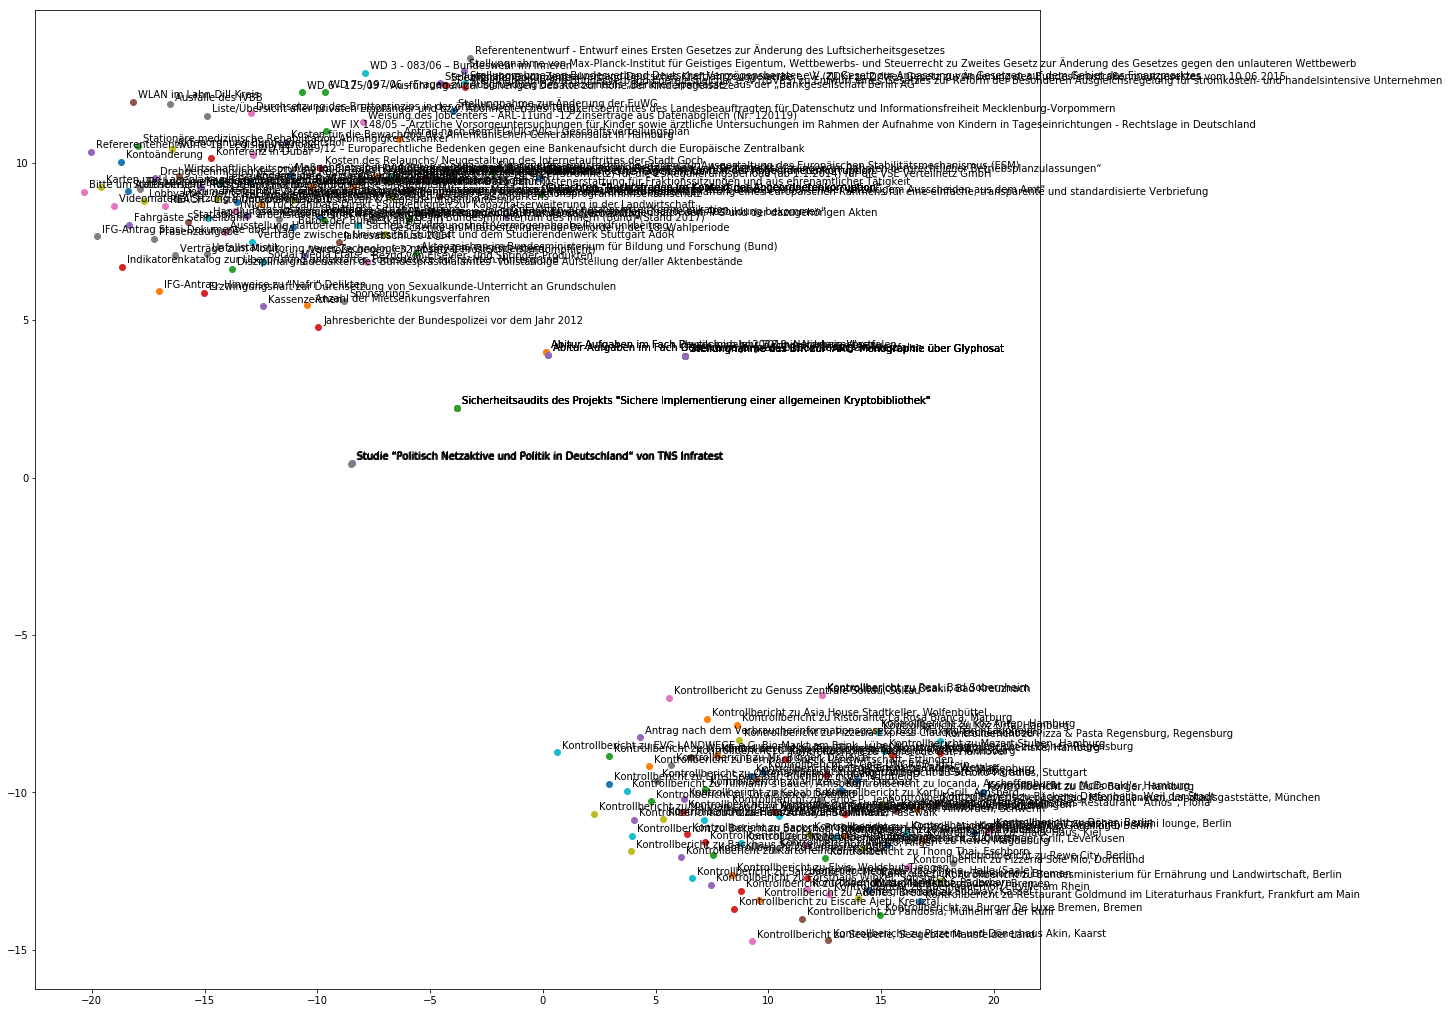

In [57]:
plot_2d_tsne(tsne_embeddings_2d, labels_2d)

In [58]:
plotly_plot_tsne(tsne_embeddings_2d, labels_2d, dimension=2)

# 3D TSNE Visualisierung für Stichprobe von Anfragen
Im finalen Abschnitt des Notebooks reduzieren wir die Dimensionen einer Stichprobe (Umfang: 200 Dokumente) mittels t-SNE auf 3D und visual

In [52]:
plot_x_docs = 200
tsne_embeddings_3d, labels_3d = compute_tsne_doc(
    data, 
    plot_x_docs, 
    dimension=3,
    perplexity=25,
    learning_rate=10,
    n_iter=1000
)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.781990
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.662976
[t-SNE] KL divergence after 1000 iterations: 0.275911


In [53]:
plotly_plot_tsne(tsne_embeddings_3d, labels_3d, dimension=3)